In order to know what I have modified, I put my code between :

 $#################
     MY CODE
 #################$

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import os
import random
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1";
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
from keras.datasets import mnist
# We have to use Concatenate
from keras.layers import Input, Dense, GaussianNoise, Dropout, LeakyReLU, Concatenate, Activation, BatchNormalization, Flatten
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys
import scipy.io as sio
import numpy as np
import argparse

In [3]:
from scipy.stats import norm 

In [4]:
class CGAN():
    def __init__(self, discriminator_path, generator_path, output_directory):
        # Input shape
        # real part and imaginary part
        self.code_dim = 2 # dimension of the input signal x
        
        # dimension with noise
        # maybe with : self.latent_dim = 10/20 
        self.latent_dim = 2 # dimension of the source z to transform with generator
        self.concat_dim = self.code_dim+self.latent_dim
        
        # If you need to save the generator and discriminator, load them from their paths
        self.discriminator_path = discriminator_path
        self.generator_path = generator_path
        self.output_directory = output_directory
        
        # we can change 0.001
        optimizer = Adam(0.001, 0.5)

        # either load them to restart the training and use them or create them from skratch
        if os.path.exists(self.discriminator_path) and os.path.exists(self.generator_path):
            self.discriminator = load_model(self.discriminator_path)
            self.generator = load_model(self.generator_path)
            print("Loaded models...")
        else:
            # Build and compile the discriminator
            self.discriminator = self.build_discriminator()
            self.discriminator.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

            # Build the generator
            
            #############################################
            self.generator = self.build_generator()
            self.generator.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
            #############################################

        # The generator takes a concatenated version of the input signal and a source of randomness
        
        # constellation symbols
        x = Input(shape=(self.code_dim,))
        z = Input(shape=(self.latent_dim,))
                
        # concatenate x with z
        
        ##################################
        x_z = Concatenate(axis=-1)([x,z])
        ##################################
        
        # Output of the medium
        y = self.generator(x_z)
        
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes real/fake channel output as input and determines validity
        valid = self.discriminator(y)
        
        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        # create the combined graph with generator and discriminator and train with binary cross entropy
        # self.combined = Model().. connect input generator and output discriminator
        
        #######################################
        # loss = binary_crossentropy
        
        self.combined = Model(inputs=[x,z], outputs=valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        #######################################
        
       
        
    def build_generator(self):

        model = Sequential()
        
        # I am not sure about input_dim=self.concat_dim
        model.add(Dense(units=512,input_dim=self.concat_dim))
        model.add(LeakyReLU(0.2))


        model.add(Dense(units=1028))
        model.add(Activation("tanh"))

        model.add(Dense(units=self.code_dim))

        #model.compile(loss='binary_crossentropy', optimizer=Adam(0.001, 0.5))
       
        model.summary()

        conc_data = Input(shape=(self.concat_dim,))
        y = model(conc_data)

        return Model(conc_data, y)

    def build_discriminator(self):

        model = Sequential()
        
        # not sure about : input_dim=self.code_dim or input_dim=self.code_dim*2
        model.add(Dense(units=1028,input_dim=self.code_dim))
        model.add(LeakyReLU(0.2))
    
    
        model.add(Dense(units=512))
        model.add(LeakyReLU(0.2))

        model.add(Dense(units=1, activation='sigmoid'))

        model.summary()

        #model.compile(loss='binary_crossentropy', optimizer=Adam(0.001, 0.5))
        y = Input(shape=(self.code_dim,))
        validity = model(y)

        return Model(y, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # fixed noise standard deviation, you can modify
        eps = 0.1

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # implement a simple QAM constellation scheme 
            # generate the channel input first and then the concatenated version..
            
            #################################
            data_tx = np.array([random.choice(([0,0], [1,0], [0,1], [1,1])) for i in range(batch_size)])
            
            # put esp*...
            source_random = np.random.normal(0, 1, (batch_size, self.latent_dim))
            data_tx_concat = np.concatenate((data_tx,source_random),axis=1)
           
            #################################
            
            # AWGN real channel
            
            #############################
            noise = eps*np.random.normal(0, 1, (batch_size, self.code_dim))
            #############################
            
            # channel real output
            data_rx = data_tx+noise

            # fake output
            
            ####################
            data_rx_generated = self.generator.predict(data_tx_concat,verbose=False)
            ####################
            
            # Train the discriminator (real classified as ones and generated as zeros)
            # train with real and generated data, first the discriminator        
            
            #######################################
            d_loss = self.discriminator.train_on_batch(np.concatenate((data_rx,data_rx_generated)),np.concatenate((valid,fake)))
            #######################################

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake generated output channels as real)
            
            ##########################
            g_loss = self.combined.train_on_batch([data_tx,source_random],valid) 
            ##########################
            
            #fill in [data_tx,source_random],[fake]

            # Plot the progress
            
            if epoch % 200 == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            
           
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                save_path = self.output_directory + f"/Models_GD_{epoch}"
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                self.discriminator.save(save_path + f"/discriminator_epoch{epoch}.h5")
                self.generator.save(save_path + f"/generator_epoch{epoch}.h5")



    def save_imgs(self, epoch):
        eps = 0.1
        # Channel input constellation diagram, only 1000 points
        # implement a simple QAM constellation scheme
        #################################
        data_tx = np.array([random.choice(([0,0], [1,0], [0,1], [1,1])) for i in range(1000)])
        source_random = np.random.normal(0, 1, (1000, self.latent_dim))
        # input of generator
        data_tx_concat = np.concatenate((data_tx,source_random),axis=1)
        #################################

        # fake output
        data_rx_generated = self.generator.predict(data_tx_concat,verbose=False)
        
        # AWGN channel
        #############################
        noise = eps*np.random.normal(0, 1, (1000, self.code_dim))
        #############################
        # channel output
        data_rx = data_tx+noise
        
        # plot real received data and the generated one
        plt.figure(figsize=(6, 4), dpi=180)
        
        plt.scatter(data_rx[:,0],data_rx[:,1], c=get_class_index(data_tx),marker="v")
        plt.scatter(data_rx_generated[:,0],data_rx_generated[:,1], c='blue',marker="^")

        plt.xlabel("In-phase amplitude of channel input")
        plt.ylabel("Quadrature amplitude of channel input")
        #plt.savefig("images/rx_const_%d.png" % epoch)
        plt.show()
        plt.figure(figsize=(6, 4), dpi=180)
        plt.scatter(data_rx_generated[:,0],data_rx_generated[:,1], c=get_class_index(data_tx),marker="o")
        plt.xlabel("In-phase amplitude of channel input")
        plt.ylabel("Quadrature amplitude of channel input")
        plt.show()
        plt.hist(data_rx_generated[:,0],bins = 25,alpha=0.5,density=True)
        plt.hist(data_rx_generated[:,1],bins = 25,alpha=0.5,density=True)
        x_axis1 = np.arange(-0.5, 0.5, 0.01) 
        x_axis2 = np.arange(0.5, 1.5, 0.01)
        plt.plot(x_axis1, norm.pdf(x_axis1, 0, eps))
        plt.plot(x_axis2, norm.pdf(x_axis2, 1, eps))
        plt.show()
        plt.close()

In [5]:
"""
the aim of this function is to create class index for displaying results later with colors
input : np.array() with such values inside: ([0,0],[1,0],[1,0],[1,1])
"""
def get_class_index(data):
    res = []
    for i in range(len(data)):
        if(np.array_equal(data[i],np.array([0,0]))):
            res.append(0)
        elif(np.array_equal(data[i],np.array([0,1]))):
            res.append(1)
        elif(np.array_equal(data[i],np.array([1,1]))):
            res.append(2)
        elif(np.array_equal(data[i],np.array([1,0]))):
            res.append(3)  
    return(res)

In [6]:
# put True if you want to train again
train = False
if train:
    # you must modified with your own path
    path_generator1_weights_file = "C:/Users/baptc/Documents/communication and deep learning/Models/generator.h5"
    path_discriminator1_weights_file = "C:/Users/baptc/Documents/communication and deep learning/Models/discriminator.h5"
    batch_size = 32
    epochs = 10000000
    # peut être plus de 500000 epochs
    epochs_between_saves_outputs = 1000
    directoy_to_save_weights_and_data = "C:/Users/baptc/Documents/communication and deep learning/Output3"
    #parser.add_argument('--output_directory', help="Directoy to save weights and data to.",default="Output")

    #args = parser.parse_args()
    resume_training = False

    cgan = CGAN(path_discriminator1_weights_file, path_generator1_weights_file, directoy_to_save_weights_and_data)

    if os.path.exists(path_discriminator1_weights_file) and os.path.exists(path_generator1_weights_file):
        if resume_training:
            cgan.train(epochs=int(epochs), batch_size=int(batch_size), save_interval=int(epochs_between_saves_outputs))
        else:
            # do nothing
            print('Generators and discriminators exist. No specific actions defined, closing')
    else:
        cgan.train(epochs=int(epochs), batch_size=int(batch_size), save_interval=int(epochs_between_saves_outputs))


In [7]:
batch_size = 32
epochs = 10000000
epochs_between_saves_outputs = 1000

In [8]:
"""
This almost the same code as you provide but as it with class function I recreate it. 
I didn't want to touch your code that the reason why I did it like that.

n : number of example you want to provide to the model and to display
"""

def plot_Model(n):    
    eps = 0.1
    # Channel input constellation diagram, only 1000 points
    # implement a simple QAM constellation scheme
    #################################
    data_tx = np.array([random.choice(([0,0], [1,0], [0,1], [1,1])) for i in range(n)])
    source_random = np.random.normal(0, 1, (n, cgan.latent_dim))
    # input of generator
    data_tx_concat = np.concatenate((data_tx,source_random),axis=1)
    #################################

    # fake output
    data_rx_generated = cgan.generator.predict(data_tx_concat,verbose=False)

    # AWGN channel
    #############################
    noise = eps*np.random.normal(0, 1, (n, cgan.code_dim))
    #############################
    # channel output
    data_rx = data_tx+noise

    # plot real received data and the generated one
    plt.figure(figsize=(6, 6), dpi=180)

    plt.scatter(data_rx[:,0],data_rx[:,1], c=get_class_index(data_tx),marker="v")
    plt.scatter(data_rx_generated[:,0],data_rx_generated[:,1], c='blue',marker="^")

    plt.xlabel("In-phase amplitude of channel input")
    plt.ylabel("Quadrature amplitude of channel input")
    #plt.savefig("images/rx_const_%d.png" % epoch)
    plt.show()
    plt.figure(figsize=(6, 6), dpi=180)
    plt.scatter(data_rx_generated[:,0],data_rx_generated[:,1], c=get_class_index(data_tx),marker="o")
    plt.xlabel("In-phase amplitude of channel input")
    plt.ylabel("Quadrature amplitude of channel input")
    plt.show()
    plt.hist(data_rx_generated[:,0],bins = 50,alpha=0.5,density=True)
    plt.hist(data_rx_generated[:,1],bins = 50,alpha=0.5,density=True)
    x_axis1 = np.arange(-0.5, 0.5, 0.01) 
    x_axis2 = np.arange(0.5, 1.5, 0.01)
    plt.plot(x_axis1, norm.pdf(x_axis1, 0, eps))
    plt.plot(x_axis2, norm.pdf(x_axis2, 1, eps))
    plt.show()
    plt.close()

Loaded models...


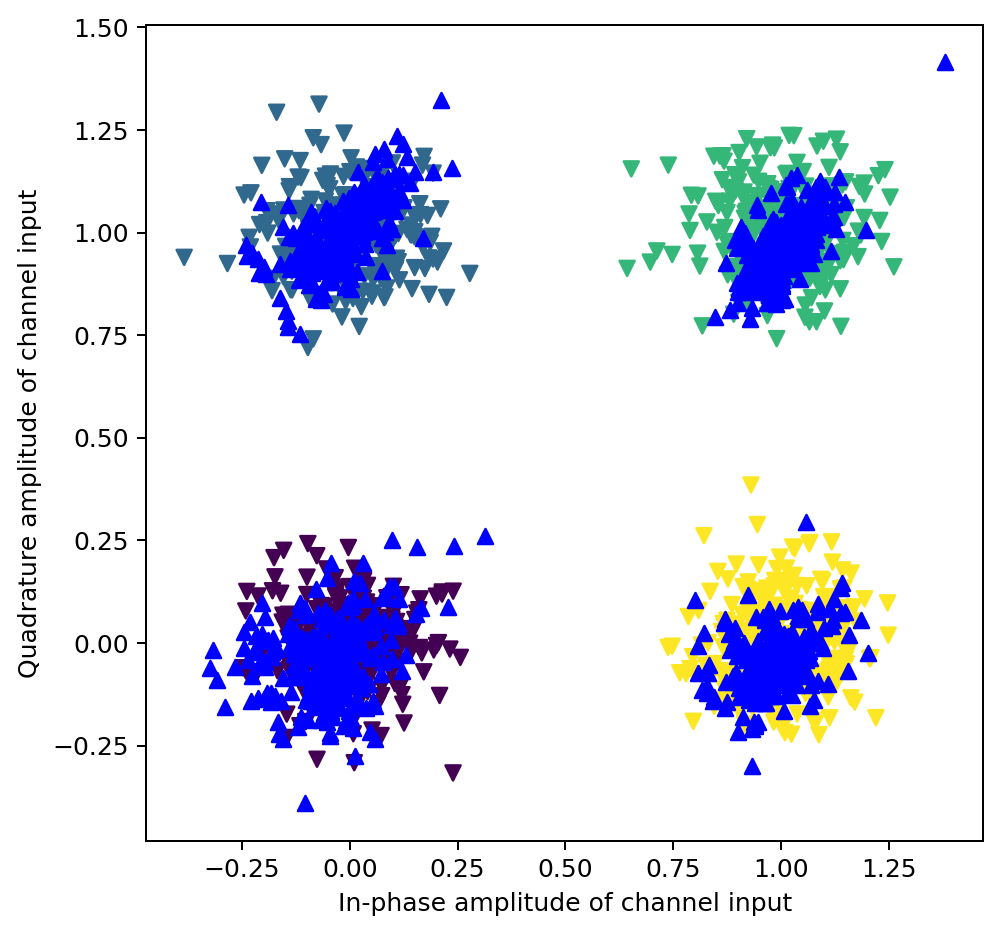

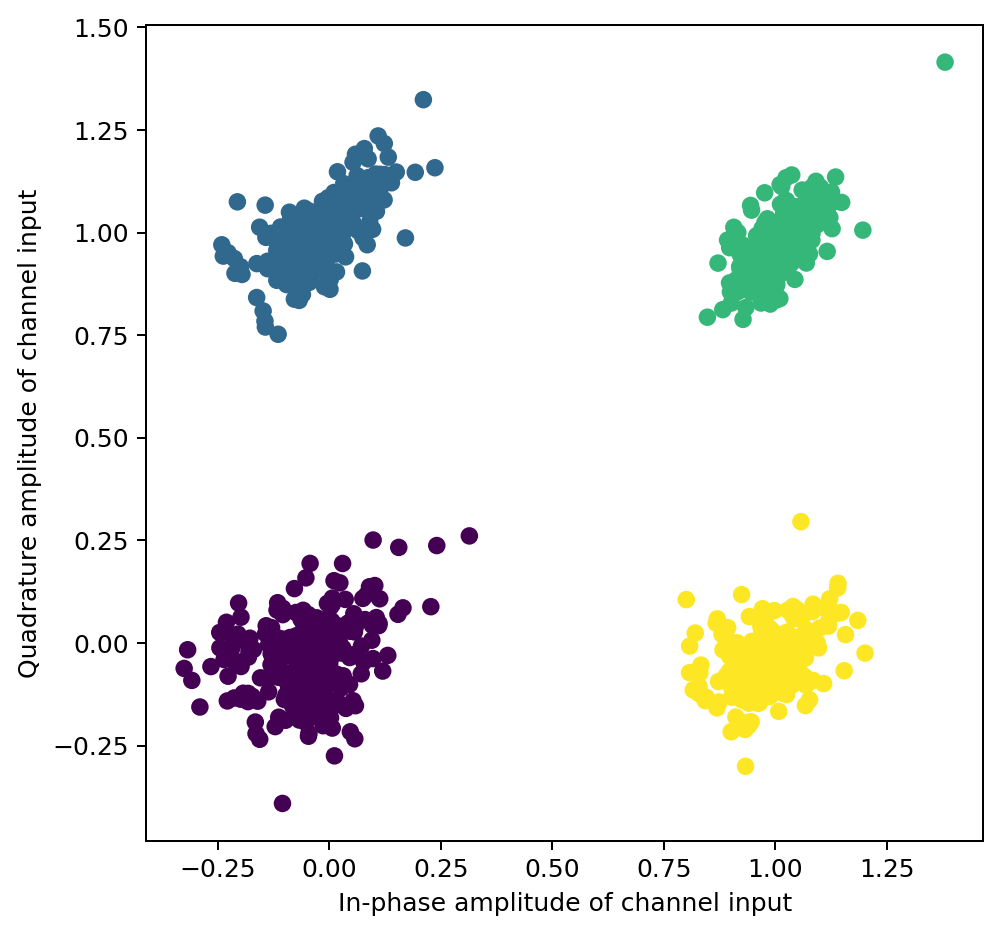

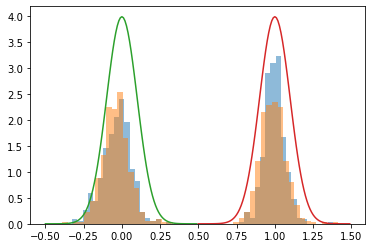

In [9]:
model_number = 146000
# for the name of the path 'generator_epoch{epoch}.h5' if forget to put f'content{}' so I didn't get the fprint but
# one can edit manually the name to have something more beautiful
directoy_to_save_weights_and_data = "C:/Users/baptc/Documents/communication and deep learning/Output2"
path_generator1_weights_file = f"C:/Users/baptc/Documents/communication and deep learning/Output2/Models_GD_{model_number}"+"//generator_epoch{epoch}.h5"
path_discriminator1_weights_file = f"C:/Users/baptc/Documents/communication and deep learning/Output2/Models_GD_{model_number}"+"//discriminator_epoch{epoch}.h5"
cgan = CGAN(path_discriminator1_weights_file, path_generator1_weights_file, directoy_to_save_weights_and_data)
plot_Model(1000)

Loaded models...


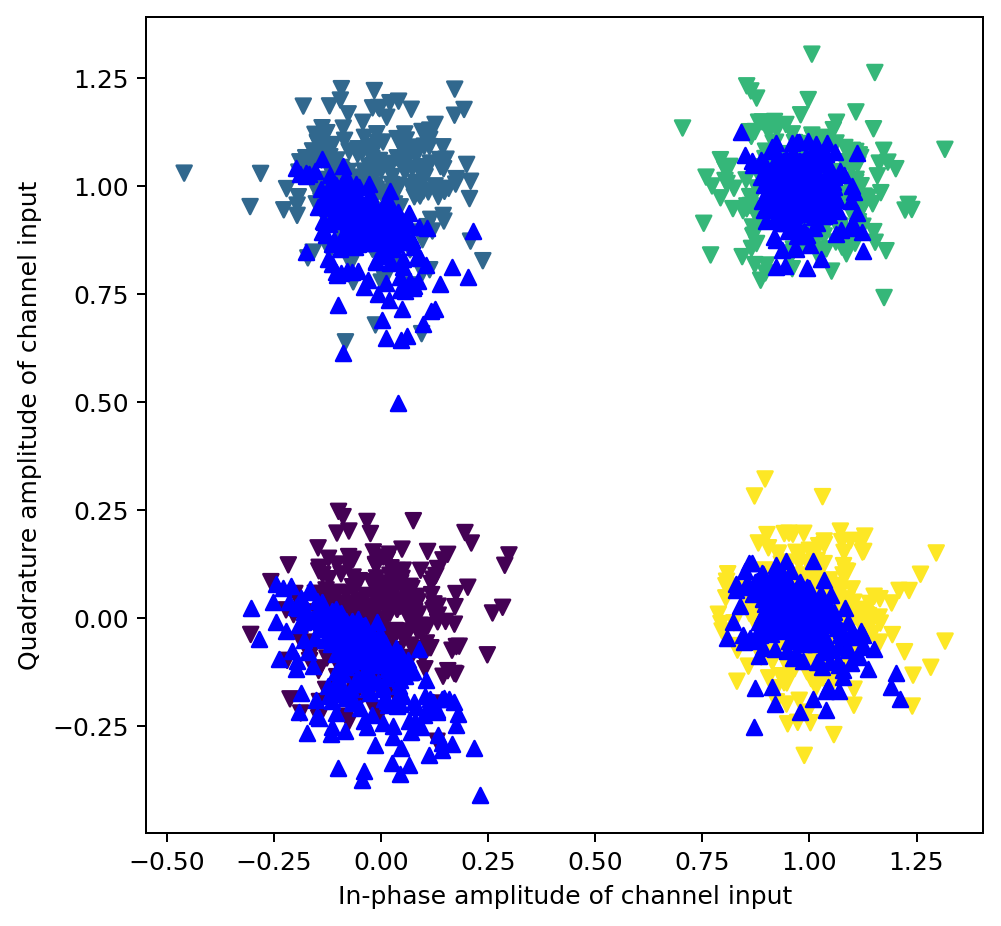

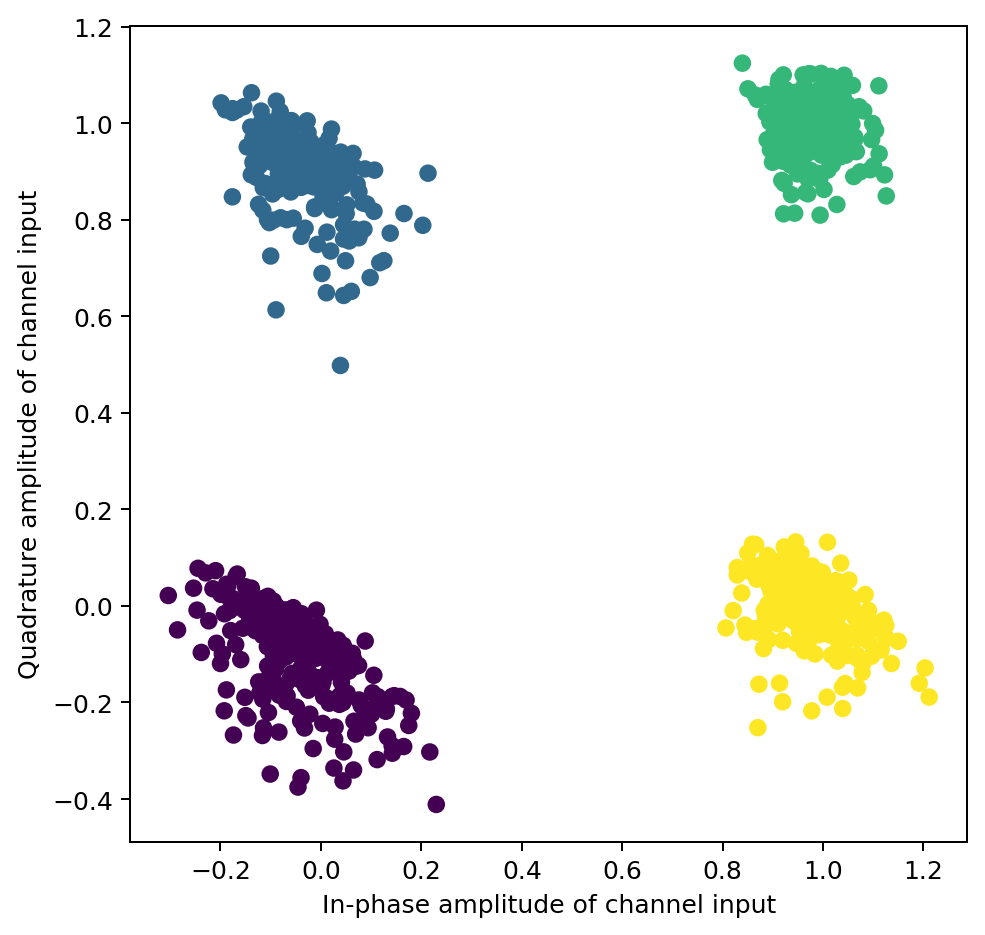

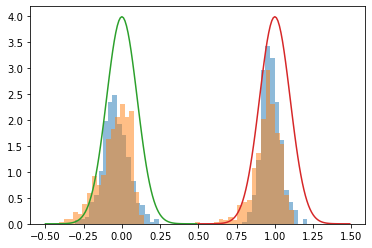

In [10]:
model_number = 84000
# for the name of the path 'generator_epoch{epoch}.h5' if forget to put f'content{}' so I didn't get the fprint but
# one can edit manually the name to have something more beautiful
directoy_to_save_weights_and_data = "C:/Users/baptc/Documents/communication and deep learning/Output2"
path_generator1_weights_file = f"C:/Users/baptc/Documents/communication and deep learning/Output2/Models_GD_{model_number}"+"//generator_epoch{epoch}.h5"
path_discriminator1_weights_file = f"C:/Users/baptc/Documents/communication and deep learning/Output2/Models_GD_{model_number}"+"//discriminator_epoch{epoch}.h5"
cgan = CGAN(path_discriminator1_weights_file, path_generator1_weights_file, directoy_to_save_weights_and_data)
plot_Model(1000)

Loaded models...


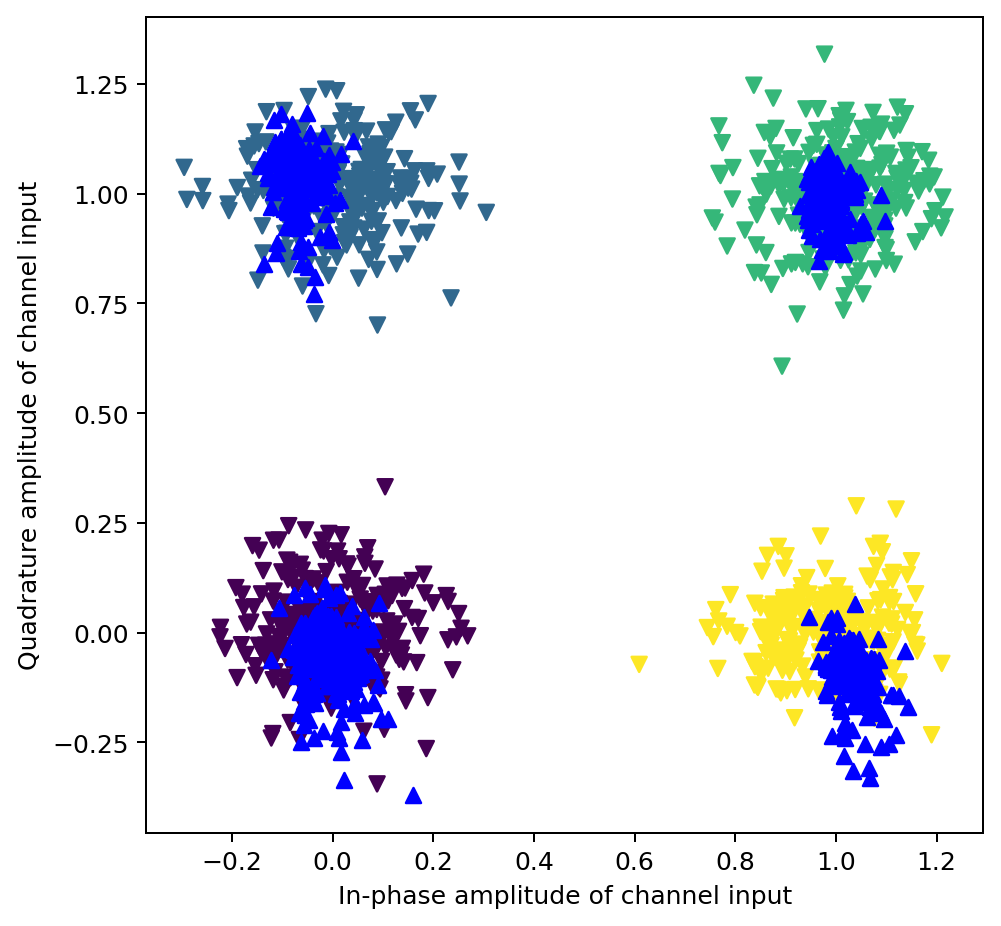

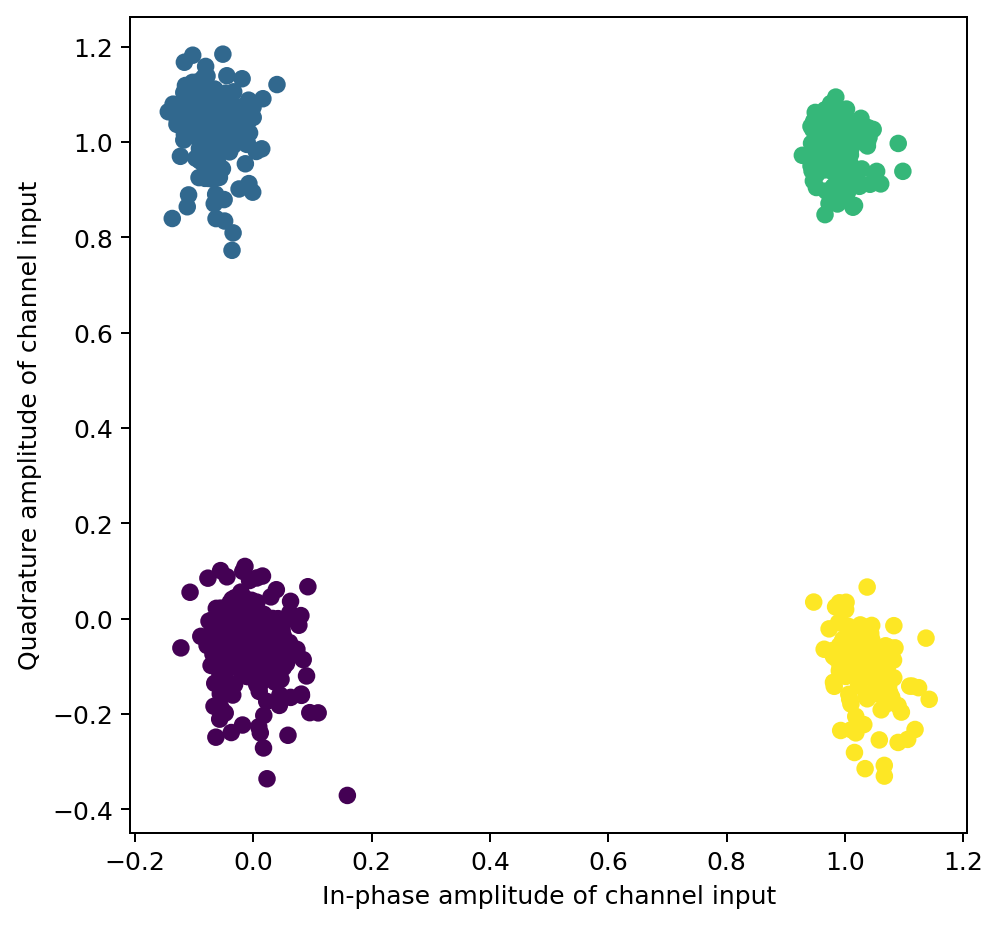

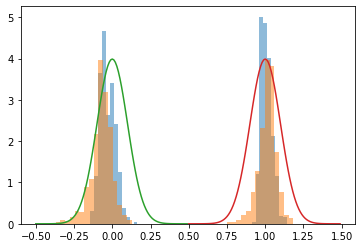

In [11]:
model_number = 74000
# for the name of the path 'generator_epoch{epoch}.h5' if forget to put f'content{}' so I didn't get the fprint but
# one can edit manually the name to have something more beautiful
directoy_to_save_weights_and_data = "C:/Users/baptc/Documents/communication and deep learning/Output2"
path_generator1_weights_file = f"C:/Users/baptc/Documents/communication and deep learning/Output2/Models_GD_{model_number}"+"//generator_epoch{epoch}.h5"
path_discriminator1_weights_file = f"C:/Users/baptc/Documents/communication and deep learning/Output2/Models_GD_{model_number}"+"//discriminator_epoch{epoch}.h5"
cgan = CGAN(path_discriminator1_weights_file, path_generator1_weights_file, directoy_to_save_weights_and_data)
plot_Model(1000)